# NAIAD Tutorial

The purpose of this tutorial is to provide a tutorial about the essential functions to train and evaluate NAIAD. We introduce:
1) NAIAD model and workflow for training a model based on genetic perturbation data and predicting new perturbations
2) Evaluation of NAIAD model performane with the increase of training data

We will use the [Norman2019](https://www.science.org/doi/10.1126/science.aax4438) combinatorial perturbation dataset, which contains cell viability measurements for CRISPRa pairwise genetic perturbations of ~120 genes.

Besides the Norman2019 dataset, you can also try out these models on the [Simpson2023](https://www.biorxiv.org/content/10.1101/2023.08.19.553986v1) and [Horlbeck2018](https://www.cell.com/cell/fulltext/S0092-8674\(18\)30735-9) datasets, present within the `./data` subfolder of this `tutorials` directory.

## Set up notebook

In [1]:
import logging
import numpy as np
import pandas as pd
import torch
import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt
from naiad import load_naiad_data, NAIAD


In [2]:
# set some configuration settings for the notebook
logging.basicConfig(level=logging.WARN)
pd.set_option("mode.copy_on_write", True)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

## NAIAD model training

In [3]:
# provide path to relevant data directories
data_file = './data/norman_gamma.csv'
result_dir = './results/naiad'

# parameters for initializing and running model
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
seed = 42
n_epoch = 100

# set up how to split data
n_train = 500 
n_val = 1000
n_test = 1000

emb_model = 'transformer-cls'



In [4]:

# load and split data
naiad_data = load_naiad_data(data_file)
naiad_model = NAIAD(naiad_data, n_train=n_train, n_val=n_val, n_test=n_test )
naiad_model.set_seed(seed=seed)
naiad_model.prepare_data()

# initialize model and prepare trainer
naiad_model.initialize_model(device=device, model_args={'embed_model': emb_model})
naiad_model.setup_trainer(n_epoch=n_epoch)

In [5]:
# run model training
naiad_model.train_model(ranking_model = False)

In [6]:
# generate predictions using the best model based on the validation loss
naiad_model.generate_preds(use_best=True)

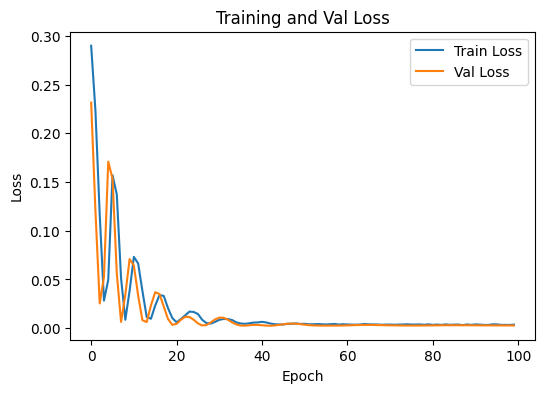

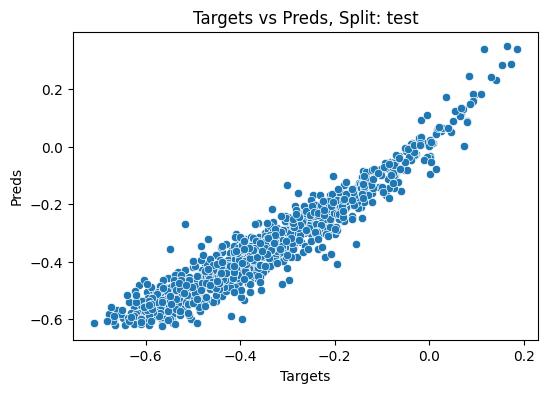

In [7]:
# plot results
fig = naiad_model.plot_loss_curves(log=False)
fig = naiad_model.plot_preds('test')

In [10]:
# extract relevant data from object
model = naiad_model.model                 # final model after training
best_model = naiad_model.best_model       # best model after training based on minimum val loss
preds = naiad_model.preds                 # predictions from best model on all data splits
losses = naiad_model.training_metrics     # train / val loss during training process
attentions = naiad_model.attentions       # attention weights from best model on all data splits

## Evaluation performance of NAIAD model with the increase of training data
Here, we demonstrate the process of training the model using replicates and evaluating how the size of the training data impacts the model's performance.

In [13]:
from naiad.utils import RunModelsReplicates


def run_model_replicates(n_ensemble,  emb_model_name, n_train_set = range(100, 3000, 200),  n_val = 1000,  n_test = 1000, n_epoch = 100):
    
    loss_metric = pd.DataFrame(columns=['val_loss_mean', 'test_loss_mean', 'val_loss_std', 'test_loss_std'], index=n_train_set, dtype=float)    
    for n_train in tqdm.tqdm(n_train_set):
        naiad_model = NAIAD(naiad_data, n_train=n_train, n_val=n_val, n_test=n_test )
        _, rep_loss = RunModelsReplicates(model=naiad_model, n_ensemble=n_ensemble, n_epoch = n_epoch, device=device, model_args={'embed_model': emb_model_name})

        # get the index of the best model based on the validation loss after 50 epochs
        rep_loss_index = list()
        for loss_i in rep_loss:
            loss_i['val_loss'][0:50] = [1]*50
            rep_loss_index.append(np.argmin(loss_i['val_loss']))

        rep_val_loss = np.array([rep_loss[i]['val_loss'][rep_loss_index[i]] for i in range(len(rep_loss)) ])
        rep_test_loss = np.array([rep_loss[i]['test_loss'][rep_loss_index[i]] for i in range(len(rep_loss)) ])
        
        loss_metric.loc[n_train] = [np.mean( rep_val_loss), np.mean(rep_test_loss),\
                                    np.std(rep_val_loss),  np.std(rep_test_loss)]
    return loss_metric


In [14]:
n_rep = 10
loss_mlp = run_model_replicates(n_ensemble=n_rep, emb_model_name='MLP')
loss_multihead = run_model_replicates(n_ensemble=n_rep, emb_model_name='multihead')
loss_transformer  = run_model_replicates(n_ensemble=n_rep, emb_model_name='transformer')
loss_transformer_cls = run_model_replicates(n_ensemble=n_rep, emb_model_name='transformer-cls')
    

100%|██████████| 15/15 [10:52<00:00, 43.50s/it]


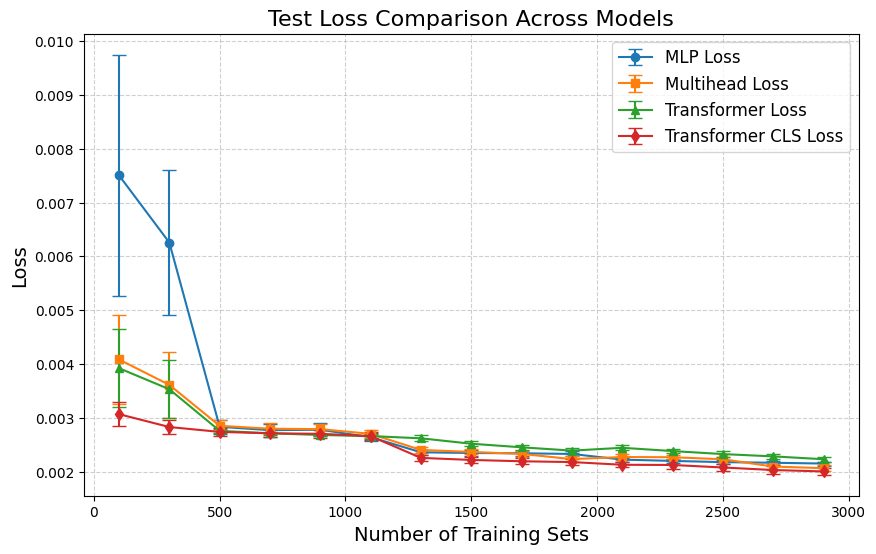

In [19]:
n_train_set = range(100, 3000, 200)
plt.figure(figsize=(10, 6))
plt.errorbar(n_train_set, loss_mlp['test_loss_mean'], yerr=loss_mlp['test_loss_std'] / np.sqrt(n_rep) , 
             label='MLP Loss', marker='o', capsize=5)
plt.errorbar(n_train_set, loss_multihead['test_loss_mean'], yerr=loss_multihead['test_loss_std'] /  np.sqrt(n_rep), 
             label='Multihead Loss', marker='s', capsize=5)
plt.errorbar(n_train_set, loss_transformer['test_loss_mean'], yerr=loss_transformer['test_loss_std'] /  np.sqrt(n_rep), 
             label='Transformer Loss', marker='^', capsize=5)
plt.errorbar(n_train_set, loss_transformer_cls['test_loss_mean'], yerr=loss_transformer_cls['test_loss_std']/ np.sqrt(n_rep), 
             label='Transformer CLS Loss', marker='d', capsize=5)

# Titles and labels
plt.title('Test Loss Comparison Across Models', fontsize=16)
plt.xlabel('Number of Training Sets', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()